In [1]:
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import glob
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/zhangxiaojie/anaconda3/envs/nlpv3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from tensorflow.python.platform import flags
import argparse
tf.app.flags.FLAGS = flags._FlagValues()
tf.app.flags._global_parser = argparse.ArgumentParser()
tf.app.flags.DEFINE_integer(flag_name="epochs", docstring="number of training epoches", default_value=10)
tf.app.flags.DEFINE_integer(flag_name="crop_height", docstring="image cropping height", default_value=500)
tf.app.flags.DEFINE_integer(flag_name="crop_width", docstring="image cropping width", default_value=500)
tf.app.flags.DEFINE_integer(flag_name="target_height", docstring="image resize height", default_value=64)
tf.app.flags.DEFINE_integer(flag_name="target_width", docstring="image resize width", default_value=64)
tf.app.flags.DEFINE_integer(flag_name="batch_size", docstring="image batchsize", default_value=128)
tf.app.flags.DEFINE_float(flag_name="learning_rate", docstring="learning rate", default_value=1e-3)
tf.app.flags.DEFINE_boolean(flag_name="is_training", docstring="whether the model is at training stage", default_value=True)

In [3]:
class DataProcess(object):
    def __init__(self, src_dir):
        self.src_dir = src_dir
        self._process()
    def _process(self):
        # Following code is according to:
        # https://stackoverflow.com/questions/33849617/how-do-i-convert-a-directory-of-jpeg-images-to-tfrecords-file-in-tensorflow
        input_files = tf.train.string_input_producer(glob.glob(os.path.join(self.src_dir,"*")), num_epochs = tf.app.flags.FLAGS.epochs)
        reader = tf.WholeFileReader()
        key, value = reader.read(input_files)
        self.labels = key
        self.imgs = tf.random_crop(tf.image.decode_jpeg(value), (tf.app.flags.FLAGS.crop_height, tf.app.flags.FLAGS.crop_width, 3))
        min_after_dequeue = 1000
        capacity = min_after_dequeue + 3 * tf.app.flags.FLAGS.batch_size
        self.label_batch, self.img_batch = tf.train.shuffle_batch([self.labels, self.imgs], \
                    batch_size=tf.app.flags.FLAGS.batch_size, capacity=capacity, min_after_dequeue=min_after_dequeue)
        # Resize The image to target size
        self.img_batch = tf.image.resize_area(self.img_batch, (tf.app.flags.FLAGS.target_height, tf.app.flags.FLAGS.target_width))
        
    def get_data(self):
        return self.label_batch, self.img_batch

In [111]:
dp = DataProcess("../dataset/102flowers/jpg/")
dp._process()

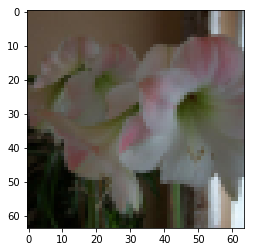

In [116]:
with tf.Session() as s:
    s.run(tf.global_variables_initializer())
    s.run(tf.local_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    try:
        while True:
            labels, imgs = s.run(dp.get_data(), feed_dict = {})
            #print(np.min(imgs))
            plt.imshow(imgs[0,:,:,:]/256.0)
            plt.show()
            break
    except tf.errors.OutOfRangeError as e:
        print("fetch data ended")
    coord.request_stop()
    coord.join(threads)

In [4]:
class Generator(object):
    """
    Generator in GAN, used to generate "fake" images
    Original paper: https://arxiv.org/pdf/1511.06434.pdf
    """
    def __init__(self):
        self._build_graph()
    def _build_graph(self):
        with tf.variable_scope("generator") as scope:
            print("### Print Generator Intermediate Parameter")
            self.prior = tf.placeholder(dtype=tf.float32, shape=(None, 100), name="prior_gen")
            self.is_training = tf.placeholder(dtype=tf.bool, shape = (), name="training_flag")
            prior_proj = tf.contrib.layers.fully_connected(inputs=self.prior, num_outputs=4*4*1024, 
                                                           activation_fn=None, scope="prior_projection")
            prior_proj = tf.contrib.layers.batch_norm(inputs=prior_proj, center=True, scale=True, activation_fn=tf.nn.relu, 
                                                  is_training= self.is_training, scope="bn0")
            conv0 = tf.reshape(prior_proj, (-1, 4, 4, 1024))
            conv1 = tf.contrib.layers.convolution2d_transpose(inputs=conv0, num_outputs=512, activation_fn=None,
                                                          kernel_size=(5,5), stride=(2,2), padding="SAME",scope="deconv1")
            conv1 = tf.contrib.layers.batch_norm(inputs=conv1, center=True, scale=True, activation_fn=tf.nn.relu, 
                                             is_training= self.is_training, scope="bn1")
            print(conv1.shape)
            conv2 = tf.contrib.layers.convolution2d_transpose(inputs=conv1, num_outputs=256, activation_fn=None,
                                                          kernel_size=(5,5), stride=(2,2), padding="SAME",scope="deconv2")
            conv2 = tf.contrib.layers.batch_norm(inputs=conv2, center=True, scale=True, activation_fn=tf.nn.relu, 
                                             is_training= self.is_training, scope="bn2")
            print(conv2.shape)
            conv3 = tf.contrib.layers.convolution2d_transpose(inputs=conv2, num_outputs=128, activation_fn=None,
                                                          kernel_size=(5,5), stride=(2,2), padding="SAME",scope="deconv3")
            conv3 = tf.contrib.layers.batch_norm(inputs=conv3, center=True, scale=True, activation_fn=tf.nn.relu, 
                                             is_training= self.is_training, scope="bn3")
            print(conv3.shape)
            conv4 = tf.contrib.layers.convolution2d_transpose(inputs=conv3, num_outputs=3, activation_fn=None,
                                                          kernel_size=(5,5), stride=(2,2), padding="SAME",scope="deconv4")
            self.gen_img = tf.nn.tanh(conv4)
            self.gen_img_out = tf.cast(x=self.gen_img*128.0 + 128.0, dtype=tf.int32)
            print(conv4.shape)
            print("### End Print Generator Intermediate Parameter")

In [118]:
# tf.reset_default_graph()
# g = Generator()

In [10]:
class Discriminator(object):
    """
    Discriminator in GAN, used to distinguish "fake" and "real" images
    """
    def __init__(self, img_gen):
        self._build_graph(img_gen)
    def _build_graph(self, image_gen):
        self.real_img = tf.placeholder(tf.float32, (None, 64, 64, 3), name="real_image")
        real_img = (self.real_img - 128.0)/128.0
        self.is_training = tf.placeholder(dtype=tf.bool, shape = (), name="training_flag")
        
        self.real_judge = self._discrim(real_img)
        #print(self.real_judge)
        self.fake_judge = self._discrim(image_gen.gen_img, reuse = True)
        #print(self.fake_judge)
    def _discrim(self, input_img, reuse = None):
        """
            This function will be called twice, 
            one for real images, and one for fake images.
        """
        with tf.variable_scope("discriminator") as scope:
            if reuse: scope.reuse_variables()
            print("### Print Discriminator Intermediate Parameter")
            
            print(self.is_training)
            conv1 = tf.contrib.layers.convolution2d(inputs=input_img, num_outputs=64, padding="SAME",
                                                    kernel_size=(3,3), stride=(1,1), activation_fn=None, scope = "conv1")
            conv1 = tf.contrib.layers.batch_norm(inputs=conv1, center=True, scale=True, activation_fn=tf.nn.leaky_relu, 
                                             is_training= self.is_training, scope="bn1")
            print(conv1.shape)
            conv2 = tf.contrib.layers.convolution2d(inputs=conv1, num_outputs=128, padding="SAME",
                                                    kernel_size=(3,3), stride=(2,2), activation_fn=None, scope = "conv2")
            conv2 = tf.contrib.layers.batch_norm(inputs=conv2, center=True, scale=True, activation_fn=tf.nn.leaky_relu, 
                                             is_training= self.is_training, scope="bn2")
            print(conv2.shape)
            ###
            conv3 = tf.contrib.layers.convolution2d(inputs=conv2, num_outputs=128, padding="SAME",
                                                    kernel_size=(3,3), stride=(1,1), activation_fn=None, scope = "conv3")
            conv3 = tf.contrib.layers.batch_norm(inputs=conv3, center=True, scale=True, activation_fn=tf.nn.leaky_relu, 
                                             is_training= self.is_training, scope="bn3")
            print(conv3.shape)
            conv4 = tf.contrib.layers.convolution2d(inputs=conv3, num_outputs=256, padding="SAME",
                                                    kernel_size=(3,3), stride=(2,2), activation_fn=None, scope = "conv4")
            conv4 = tf.contrib.layers.batch_norm(inputs=conv4, center=True, scale=True, activation_fn=tf.nn.leaky_relu, 
                                             is_training= self.is_training, scope="bn4")
            print(conv4.shape)
            ###
            conv5 = tf.contrib.layers.convolution2d(inputs=conv4, num_outputs=256, padding="SAME",
                                                    kernel_size=(3,3), stride=(1,1), activation_fn=None, scope = "conv5")
            conv5 = tf.contrib.layers.batch_norm(inputs=conv5, center=True, scale=True, activation_fn=tf.nn.leaky_relu, 
                                             is_training= self.is_training, scope="bn5")
            print(conv5.shape)
            conv6 = tf.contrib.layers.convolution2d(inputs=conv5, num_outputs=1024, padding="SAME",
                                                    kernel_size=(3,3), stride=(2,2), activation_fn=None, scope = "conv6")
            conv6 = tf.contrib.layers.batch_norm(inputs=conv6, center=True, scale=True, activation_fn=tf.nn.leaky_relu, 
                                             is_training= self.is_training, scope="bn6")
            print(conv6.shape)
            conv7 = tf.contrib.layers.convolution2d(inputs=conv6, num_outputs=1024, padding="SAME",
                                                    kernel_size=(3,3), stride=(1,1), activation_fn=None, scope = "conv7")
            conv7 = tf.contrib.layers.batch_norm(inputs=conv7, center=True, scale=True, activation_fn=tf.nn.leaky_relu, 
                                             is_training= self.is_training, scope="bn7")
            print(conv7.shape)
            conv8 = tf.contrib.layers.convolution2d(inputs=conv7, num_outputs=2048, padding="SAME",
                                                    kernel_size=(3,3), stride=(2,2), activation_fn=None, scope = "conv8")
            conv8 = tf.contrib.layers.batch_norm(inputs=conv8, center=True, scale=True, activation_fn=tf.nn.leaky_relu, 
                                             is_training= self.is_training, scope="bn8")
            print(conv8.shape)
            conv9 = tf.contrib.layers.convolution2d(inputs=conv8, num_outputs=102, padding="SAME",
                                                    kernel_size=(1,1), stride=(1,1), activation_fn=tf.nn.leaky_relu, scope="conv9")
            conv9 = tf.contrib.layers.avg_pool2d(inputs=conv9, kernel_size=(4,4), stride=(4,4), padding="SAME", scope="avg_pool9")
            print(conv9.shape)
            print("### End Print Discriminator Intermediate Parameter")
            ### no need to perform sigmoid
            return tf.contrib.layers.fully_connected(inputs=tf.reshape(conv9,(-1, 102)), num_outputs=1, 
                                                     activation_fn=None, scope="output_projection")
            

In [120]:
# tf.reset_default_graph()
# g = Generator()
# d = Discriminator(g)

In [121]:
# tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')

In [122]:
# tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')

In [12]:
class GANModel(object):
    def __init__(self, generator, discriminator, datasrc):
        self.generator = generator
        self.discriminator = discriminator
        self.datasrc = datasrc
        self.sess = None
        self.saver = tf.train.Saver()
    def train(self, model_path = None):
        self.sess = tf.Session()
        fake_result = self.discriminator.fake_judge
        real_result = self.discriminator.real_judge
        fake_rate = tf.reduce_mean(tf.cast(tf.nn.sigmoid(fake_result) > 0.5, tf.float32))
        loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_result , labels = tf.ones_like(fake_result)))
        loss_d = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_result , labels = tf.ones_like(real_result)))\
               + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_result , labels = tf.zeros_like(fake_result)))
        optim_g = tf.train.AdamOptimizer(tf.app.flags.FLAGS.learning_rate).minimize(loss_g, var_list = \
                                                           tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator'))
        optim_d = tf.train.AdamOptimizer(tf.app.flags.FLAGS.learning_rate).minimize(loss_d, var_list = \
                                                           tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator'))
        writer = tf.summary.FileWriter("./log")
        summary_g = tf.summary.scalar(name="generator_loss", tensor=loss_g)
        summary_d = tf.summary.scalar(name="discriminator_loss", tensor=loss_d)
        summary_fake_rate = tf.summary.scalar(name="fake_rate", tensor=fake_rate)
        
        if model_path:
            self.saver.restore(self.sess, model_path)
            
        self.sess.run(tf.global_variables_initializer())
        self.sess.run(tf.local_variables_initializer())
        
        cnt_total = 0
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord, sess=self.sess)
        try:
            while True:
                labels, imgs = self.sess.run(self.datasrc.get_data(), feed_dict = {})
                # First train discriminator
                # print(self.discriminator.is_training)
                # print(self.generator.is_training)
                loss_d_out, _, summary_d_out = self.sess.run([loss_d, optim_d, summary_d], 
                                                                 feed_dict = {
                                                                      self.discriminator.real_img: imgs,
                                                                      self.generator.prior: \
                                                                           np.random.randn(tf.app.flags.FLAGS.batch_size, 100)*1e-2,
                                                                      self.discriminator.is_training: True,
                                                                      self.generator.is_training: True
                                                                })
                # Then train generator
                loss_g_out, _, summary_g_out = self.sess.run([loss_g, optim_g, summary_g], 
                                                                 feed_dict = {
                                                                      self.generator.prior: \
                                                                           np.random.randn(tf.app.flags.FLAGS.batch_size, 100)*1e-2,
                                                                      self.discriminator.is_training: True,
                                                                      self.generator.is_training: True,
                                                                })
                # Then evaluate the fake ratio
                fake_rate_out, summary_fake_rate_out = self.sess.run([fake_rate, summary_fake_rate],
                                                                        feed_dict = {
                                                                            self.generator.prior: \
                                                                                np.random.randn(tf.app.flags.FLAGS.batch_size, 100)*1e-2,
                                                                            self.discriminator.is_training: False,
                                                                            self.generator.is_training: False,
                                                                        })
                cnt_total += 1       
                writer.add_summary(summary_d_out, cnt_total)
                writer.add_summary(summary_g_out, cnt_total)
                writer.add_summary(summary_fake_rate_out, cnt_total)
                
                print("In batch %3d, Dicriminator Loss %.3f, Generator Loss %.3f, Fake Ratio %.3f\r" \
                      %(cnt_total, loss_d_out, loss_g_out, fake_rate_out), end="")
                # Save every 100 batches
                if cnt_total % 50 == 0:
                    self.saver.save(self.sess, "./log/model_%3d.ckpt" %(cnt_total//50))
                    
        except tf.errors.OutOfRangeError as e:
            print("fetch data ended")
        coord.request_stop()
        coord.join(threads)
        
    def infer_gen(self, model_path = None, n_img = 1, prior=None):
        """
            After the training, now we can use generator images!
            n_img: number of images, if not given any prior
            prior: given priors, if None, then random generate
        """
        if not self.sess:
            self.sess = tf.Session()
        if not model_path:
            print("Invalid model path!")
            sys.exit()
        else:
            self.saver.restore(self.sess, model_path)
            
        if not prior:
            prior = np.random.randn(n_img, 100)* 1e-2
            
        imgs = self.sess.run(self.generator.gen_img_out, feed_dict = {self.generator.prior: prior, self.generator.is_training: False})
        return imgs
            
    def infer_dis(self):
        """
            In fact, discriminator can be used to predict,
            but here we will not complete the code
        """
        pass

In [ ]:
if __name__ == "__main__":
    tf.reset_default_graph()
    dp = DataProcess("../dataset/102flowers/jpg/")
    g = Generator()
    d = Discriminator(g)
    gan = GANModel(generator=g, discriminator=d, datasrc=dp)
    gan.train()

### Print Generator Intermediate Parameter
(?, 8, 8, 512)
(?, 16, 16, 256)
(?, 32, 32, 128)
(?, 64, 64, 3)
### End Print Generator Intermediate Parameter
### Print Discriminator Intermediate Parameter
Tensor("training_flag:0", shape=(), dtype=bool)
(?, 64, 64, 64)
(?, 32, 32, 128)
(?, 32, 32, 128)
(?, 16, 16, 256)
(?, 16, 16, 256)
(?, 8, 8, 1024)
(?, 8, 8, 1024)
(?, 4, 4, 2048)
(?, 1, 1, 102)
### End Print Discriminator Intermediate Parameter
### Print Discriminator Intermediate Parameter
Tensor("training_flag:0", shape=(), dtype=bool)
(?, 64, 64, 64)
(?, 32, 32, 128)
(?, 32, 32, 128)
(?, 16, 16, 256)
(?, 16, 16, 256)
(?, 8, 8, 1024)
(?, 8, 8, 1024)
(?, 4, 4, 2048)
(?, 1, 1, 102)
### End Print Discriminator Intermediate Parameter
